# Imports

In [40]:
import numpy as np
import pandas as pd
import fitz as fitz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
from typing import Optional

# Code

## Constants

In [41]:
# name of the master tracking sheet file
master_tracker_path: str = "../assets/tracker_images/Master Visitor Tracker Sheet.pdf"

# relative file path
data_path: str = "../assets/excel_files/observation_tables.xlsx"

# sheet name
main_sheet_name: str = "main data"

# export path
export_path: str = "../assets/output_files/room_18_path_heatmap.png"

## Loading XLSX

In [42]:
xlsx: pd.ExcelFile = pd.ExcelFile(data_path)
visitor_df: pd.DataFrame = pd.read_excel(xlsx, sheet_name=main_sheet_name, index_col=0)

## Operations

### Support Functions

In [43]:
def get_paths_list(df: pd.DataFrame) -> list[str]:
	"""
	Extracts a list of file paths from a specific column in a DataFrame.

	Args:
		df: The pandas DataFrame containing the path data.

	Returns:
		A list of string paths extracted from the "tracker_map_path" column.
	"""
	return df["tracker_map_path"].to_list()

def validate_points(x: float, y: float) -> bool:
	"""
	Validates if a coordinate point falls within acceptable boundaries.

	Checks against general Y-limits and specific rectangular restriction zones
	where points should be ignored.

	Args:
		x: The x-coordinate to validate.
		y: The y-coordinate to validate.

	Returns:
		True if the point is within valid bounds and not in a restricted zone,
		False otherwise.

	Raises:
		Exception: If restriction lists are mismatched in length.
	"""
	y_min_limit: float = 75.0 
	y_max_limit: float = 525.0
	x_restrictions: list[tuple[float, float]] = [
		(260, 330),
		(200, 400)
	]
	y_restrictions: list[tuple[float, float]] = [
		(250, 375),
		(300, 375)
	]
	if len(x_restrictions) != len(y_restrictions):
		raise Exception("Restrictions incomplete: x and y lists must be same length")

	not_restricted: bool = True
	for i in range(len(x_restrictions)):
		if y_restrictions[i][0] < y < y_restrictions[i][1] and x_restrictions[i][0] < x < x_restrictions[i][1]:
			not_restricted = False

	return y_min_limit < y < y_max_limit and not_restricted

def get_visitor_data(paths: list[str]) -> np.ndarray:
	"""
	Analyzes multiple PDFs to find red tracking marks and calculate density.

	Processes PDFs to detect red pixels (representing visitor paths), converts
	coordinates, validates them, and counts occurrences of unique points.

	Args:
		paths: A list of paths to individual visitor tracking PDFs.

	Returns:
		A numpy array of shape (N, 3) where each row is [x, y, count],
		representing the unique point and how many paths passed through it.
	"""
	intensity_counter: Counter[tuple[int, int]] = Counter()
	
	for path in paths:
		path_doc: fitz.Document = fitz.open(path)
		path_page: fitz.Page = path_doc[0]

		pixmap: fitz.Pixmap = path_page.get_pixmap(matrix=fitz.Matrix(2, 2))
		img: np.ndarray = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)

		red_mask: np.ndarray = (img[:, :, 0] > 200) & (img[:, :, 1] < 50) & (img[:, :, 2] < 50)
		
		red_indices: np.ndarray = np.argwhere(red_mask)

		counted_for_path: list[tuple[int, int]] = []
		
		for y, x in red_indices:
			real_x: float = x / 2.0
			real_y: float = y / 2.0 - 75
			
			if ((int(real_x), int(real_y)) not in counted_for_path) and validate_points(real_x, real_y):
				counted_for_path.append((int(real_x), int(real_y)))
				intensity_counter[(int(real_x), int(real_y))] += 1
		
		path_doc.close()
	
	data_list: list[list[int]] = []
	for (x, y), count in intensity_counter.items():
		if count > 95:
			print((x, y))
		data_list.append([x, y, count])
		
	return np.array(data_list)

def generate_map_overlay(base_pdf_path: str, points: np.ndarray) -> None:
	"""
	Generates and saves a heatmap overlay on top of the base PDF map.

	Args:
		base_pdf_path: Path to the base map PDF to use as background.
		points: A numpy array of shape (N, 3) containing [x, y, count] data.

	Raises:
		Exception: If `points` array is empty or improperly formatted.
	"""
	if points.size == 0 or points.ndim < 2:
		raise Exception("No data available to plot.")
	
	doc: fitz.Document = fitz.open(base_pdf_path)
	page: fitz.Page = doc[0]

	pixmap: fitz.Pixmap = page.get_pixmap(dpi=150, annots=False)
	
	width: float = page.rect.width
	height: float = page.rect.height
	
	img_data: np.ndarray = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(
		pixmap.h, pixmap.w, pixmap.n
	)

	fig: plt.Figure
	ax: plt.Axes
	fig, ax = plt.subplots(figsize=(width / 72, height / 72))

	ax.imshow(img_data, extent=[0, width, height, 0])

	sc = ax.scatter(
		points[:, 0],
		points[:, 1],
		c=points[:, 2],
		cmap="YlOrRd",
		s=5,
		alpha=0.6
	)

	ax.set_ylim(height, 0)
	ax.set_xlim(0, width)

	ax.set_title("Room 18 Visitor Density Heatmap")
	ax.axis("off")
	
	cbar = plt.colorbar(
		sc,
		ax=ax,
		label='Unique Paths Passing Through'
	)
	cbar.ax.yaxis.label.set_rotation(270)
	cbar.ax.yaxis.labelpad = 20
	cbar.ax.yaxis.label.set_verticalalignment('center')

	plt.savefig(export_path, dpi=300, bbox_inches='tight')
	plt.show()
	
	doc.close()

### Execution

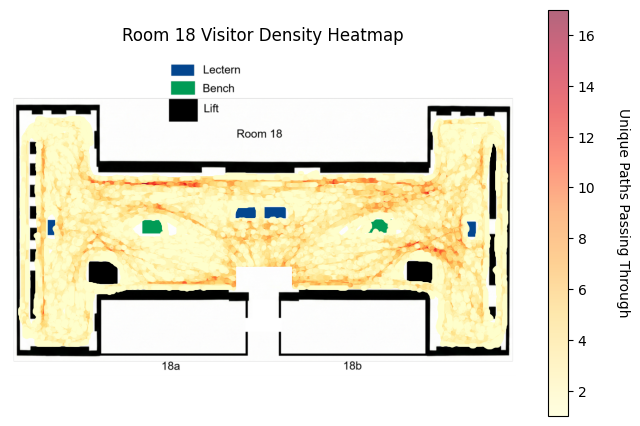

In [44]:
tracker_file_paths: list[str] = get_paths_list(visitor_df)
points: np.ndarray = get_visitor_data(tracker_file_paths)
generate_map_overlay(master_tracker_path, points)